# Weather data analysis

Проведем анализ данных о погоде. Импортируем нужные библиотеки.

In [2]:
import os
os.chdir("..")
os.chdir("..")
import pyrssa as prs
os.chdir("./examples/weather")

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(1)

## Data visualization

Считаем данные.

In [62]:
df = pd.read_csv("weather5.csv")
df.head()

,x
0,36.93
1,37.72
2,29.24
3,22.94
4,12.76


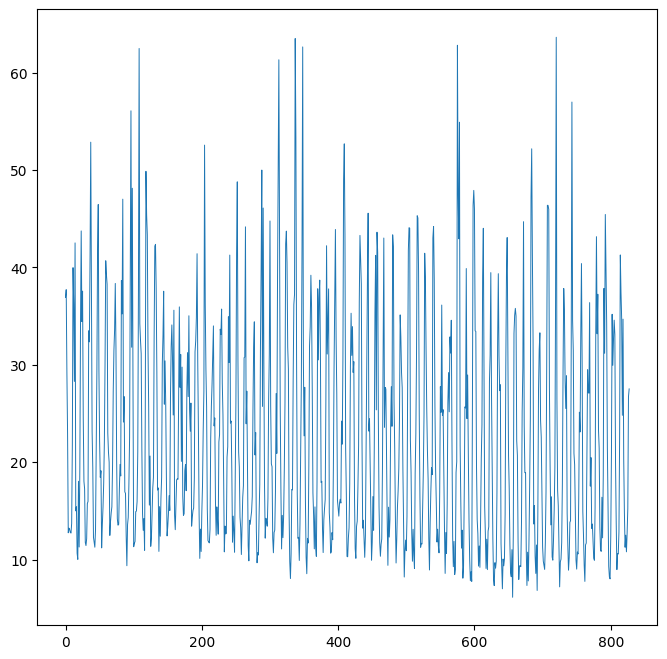

In [63]:
plt.rcParams["figure.figsize"] = (8, 8)
ts = pd.Series(df.x.values)
plt.plot(ts, linewidth=0.7)
plt.show()

## Basic SSA

Построим базовый SSA, выбрав L, основываясь на предположении о том, что погодные данные имеют период в один год.

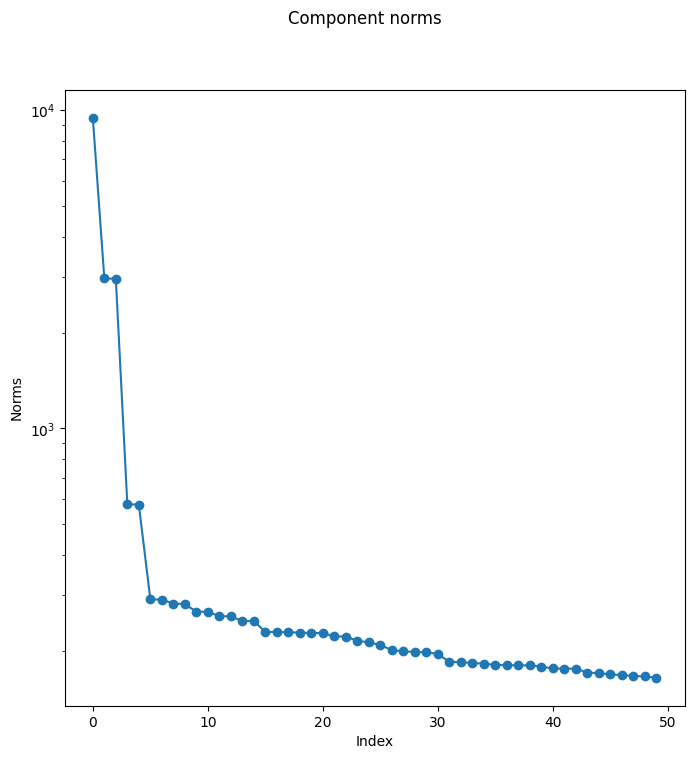

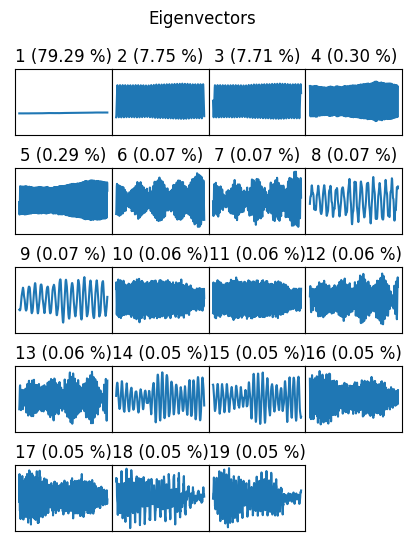

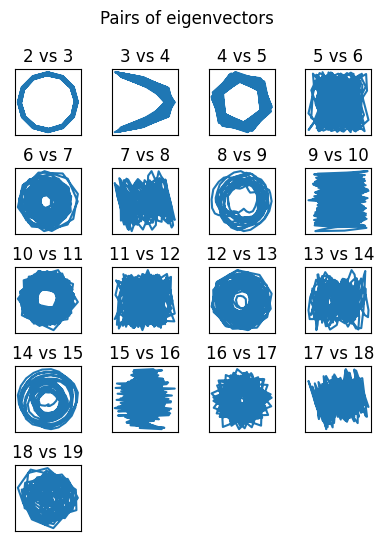

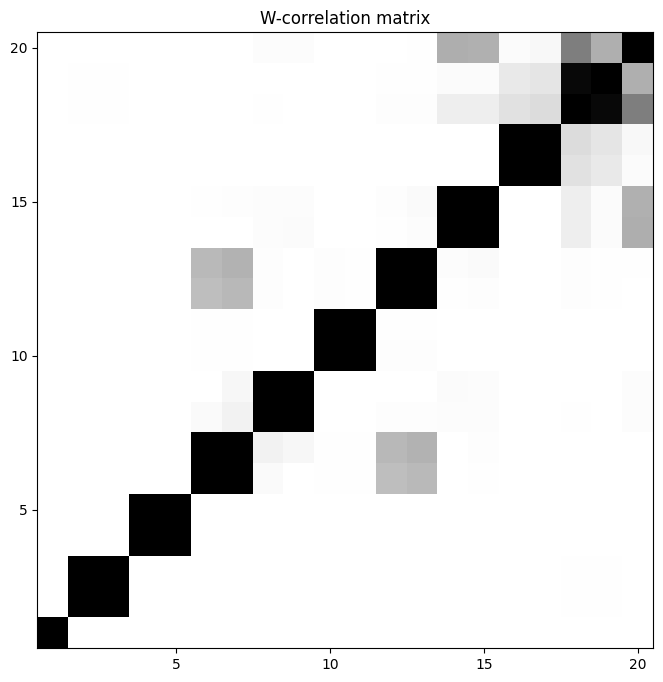

In [85]:
ts_ssa = prs.ssa(ts, L=len(ts) // 2 // 12 * 12, kind="1d-ssa")
prs.plot(ts_ssa)
prs.plot(ts_ssa, kind="vectors", idx=range(1, 20))
prs.plot(ts_ssa, kind="paired", idx=range(2, 20), contrib=False)
prs.plot(prs.wcor(ts_ssa, groups=range(1, 21)), scales=range(5, 21, 5))

ssa_results = {'Basic': []}

In [86]:
print(prs.parestimate(ts_ssa, groups={"Trend": 1, "Seasonality": range(2, 14)}, method="esprit"))

$Trend
   period     rate   |    Mod     Arg  |     Re        Im
      Inf  -0.000178 |  0.99982   0.00 |  0.99982   0.00000

$Seasonality
   period     rate   |    Mod     Arg  |     Re        Im
    7.280   0.000210 |  1.00021   0.86 |  0.65028   0.75997
   -7.280   0.000210 |  1.00021  -0.86 |  0.65028  -0.75997
    5.993   0.000178 |  1.00018   1.05 |  0.49909   0.86676
   -5.993   0.000178 |  1.00018  -1.05 |  0.49909  -0.86676
   11.997   0.000149 |  1.00015   0.52 |  0.86609   0.50019
  -11.997   0.000149 |  1.00015  -0.52 |  0.86609  -0.50019
   28.298  -0.000185 |  0.99982   0.22 |  0.97527   0.22018
  -28.298  -0.000185 |  0.99982  -0.22 |  0.97527  -0.22018
    7.943  -0.000917 |  0.99908   0.79 |  0.70249   0.71040
   -7.943  -0.000917 |  0.99908  -0.79 |  0.70249  -0.71040
    4.772  -0.001451 |  0.99855   1.32 |  0.25101   0.96649
   -4.772  -0.001451 |  0.99855  -1.32 |  0.25101  -0.96649




Среди сезонных компонент выделяются периоды 6 и 12 (компоненты 2-3, 4-5), а также 7, 28 и 4.

Исходя из корреляционной матрицы заметно смешивание компонент (5, 6) и (7, 8), (11, 12).

Также после 13 компоненты видно заметное смешивание компонент между собой.

Построим восстановление ряда.

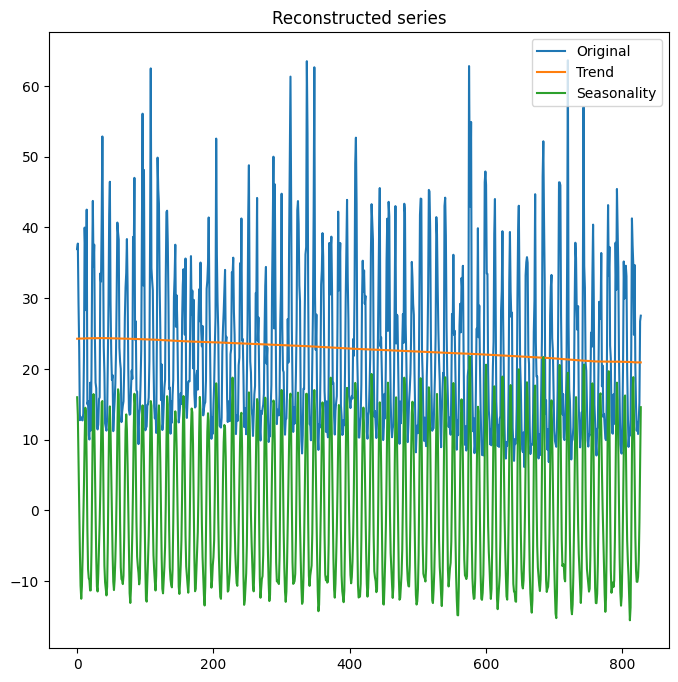

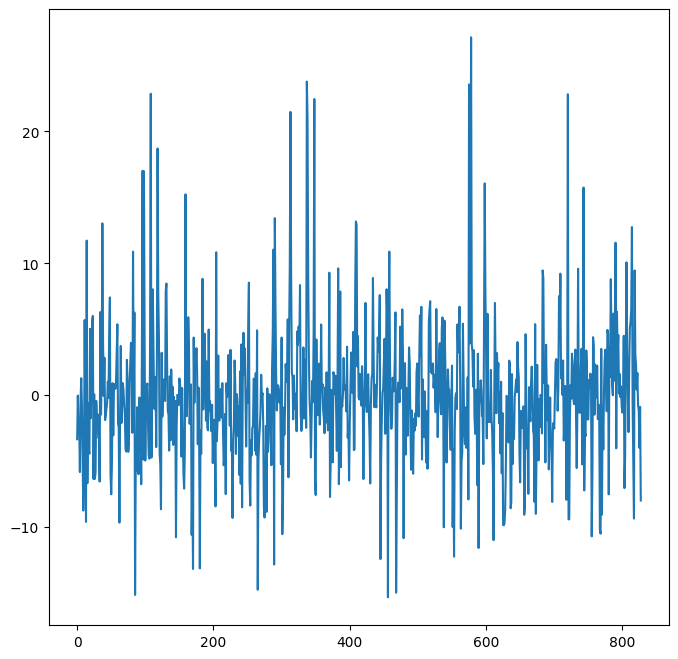

In [87]:
ts_rec = prs.reconstruct(ts_ssa, groups={"Trend": 1, "Seasonality": range(2, 12)})
prs.plot(ts_rec, superpose=True, add_residuals=False)
plt.plot(ts_rec.residuals)
plt.show()

Теперь восстановим сигнал, не разделяя на тренд и сезонность.

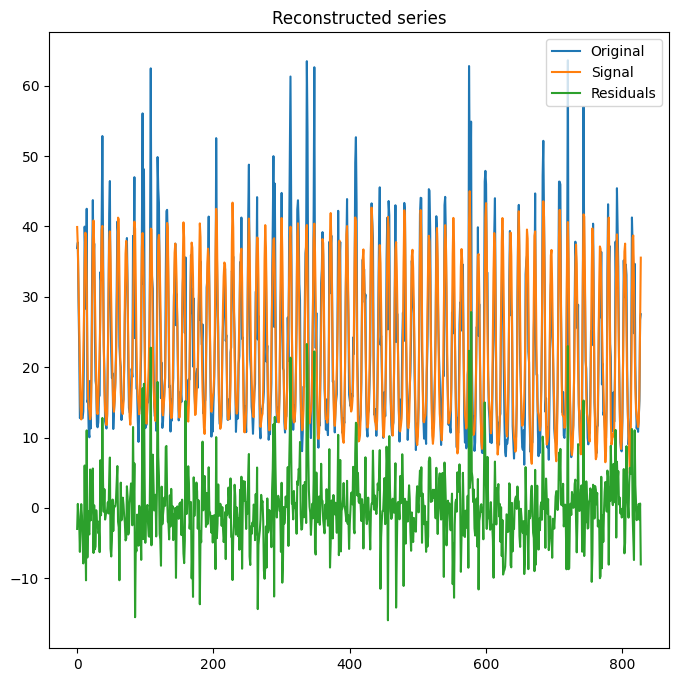

In [88]:
ts_rec = prs.reconstruct(ts_ssa, groups={"Signal": range(1, 14)})
prs.plot(ts_rec, superpose=True)

Построим оценку по MSPE.

In [89]:
ts_mspe = 100 * np.mean( np.sqrt(( (ts - ts_rec.Signal) / ts )**2)) 
ts_mspe

16.63616585611897

Ошибка восстановления составила 16.63%

По графику видно, что восстановление не учитывает некоторые всплески, которые происходят в различные моменты, и все они отнесены к шуму.

## Forecast

Попробуем отрезать часть ряда, например, последние 5 лет, и построить прогноз на основе известных данных, а затем оценить качество прогноза.

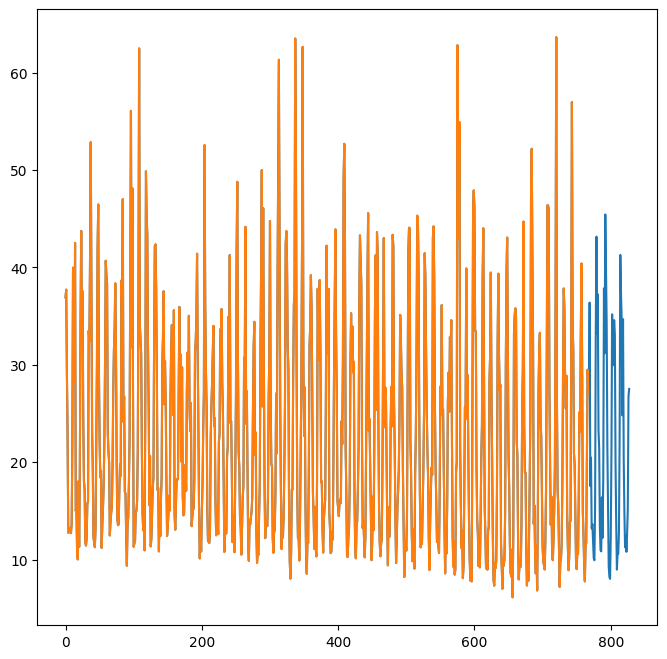

In [90]:
ts_recent = ts[:-(12 * 5)]
ts_actual = ts[-(12 * 5):]
plt.plot(ts)
plt.plot(ts_recent)
plt.show()

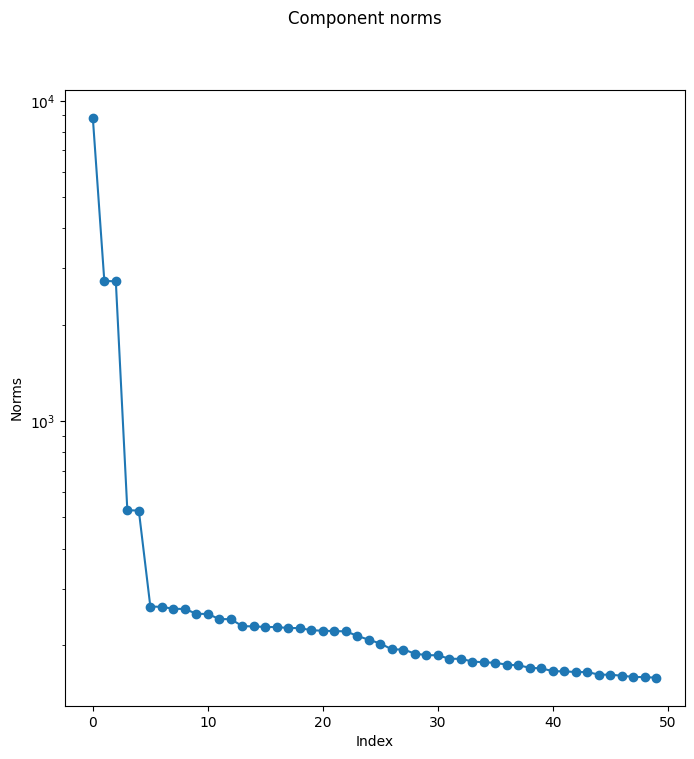

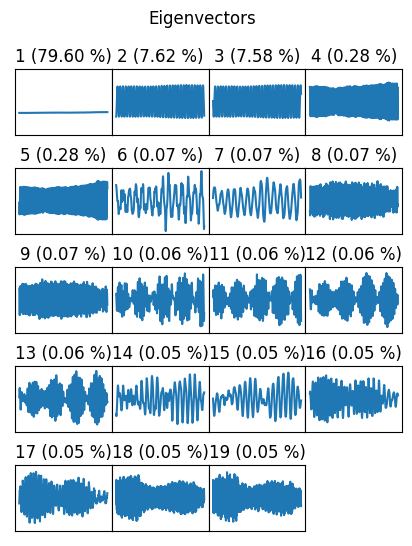

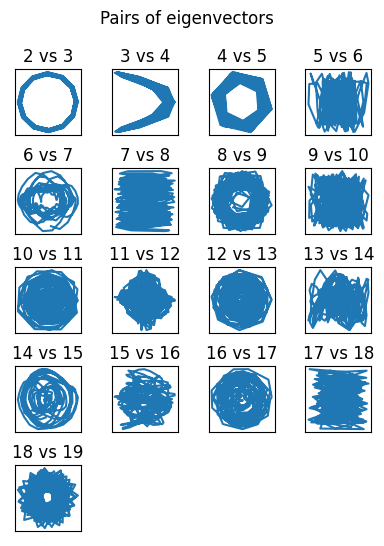

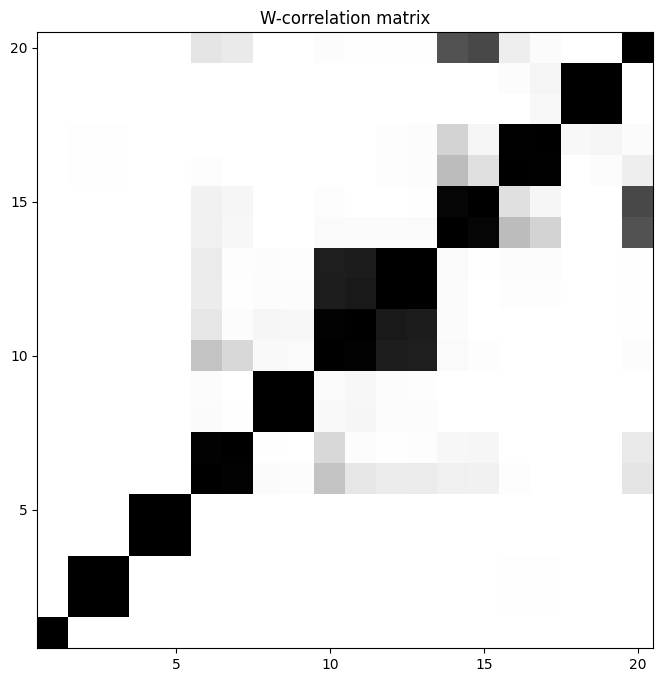

In [91]:
ts_ssa = prs.ssa(ts_recent, L=len(ts_recent) // 2 // 12 * 12, kind="1d-ssa")
prs.plot(ts_ssa)
prs.plot(ts_ssa, kind="vectors", idx=range(1, 20))
prs.plot(ts_ssa, kind="paired", idx=range(2, 20), contrib=False)
prs.plot(prs.wcor(ts_ssa, groups=range(1, 21)), scales=range(5, 21, 5))

Как видно, в данном случае заметно смешались между собой (10, 11) и (12, 13). Однако, если мы отнесем их к сигналу, необходимости в отделении их друг от друга нет.

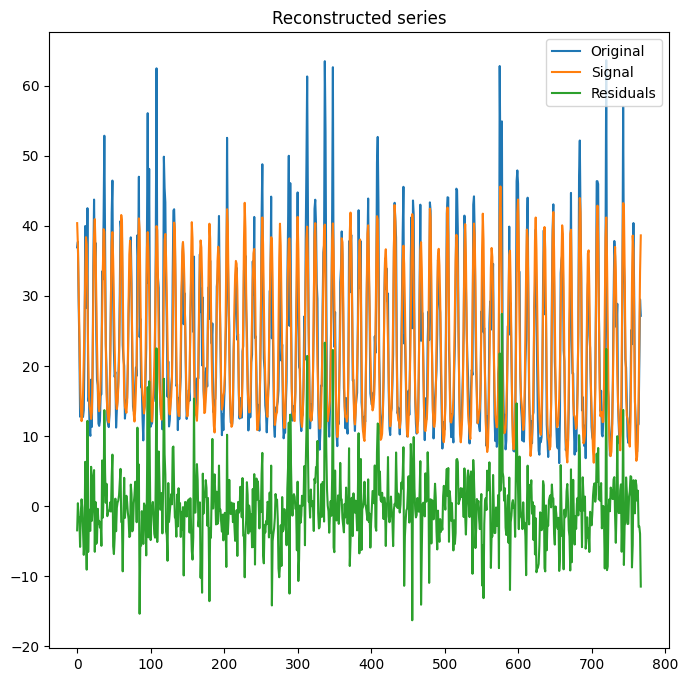

In [92]:
ts_rec = prs.reconstruct(ts_ssa, groups={"Signal": range(1, 14)})
prs.plot(ts_rec, superpose=True)

In [93]:
ts_mspe = 100 * np.mean( np.sqrt(( (ts_recent - ts_rec.Signal) / ts )**2)) 
ssa_results['Basic'] = {'Reconstruct_14': ts_mspe}
print(ts_mspe)

16.62997710434034


Ошибка составила 16.29%, на одну сотую процента меньше, чем прошлом случае.

Однако, для устойчивости прогноза данное число компонент может быть не самым удачным. Исходя из первого графика с нормами компонент, рассмотрим также первые 5.

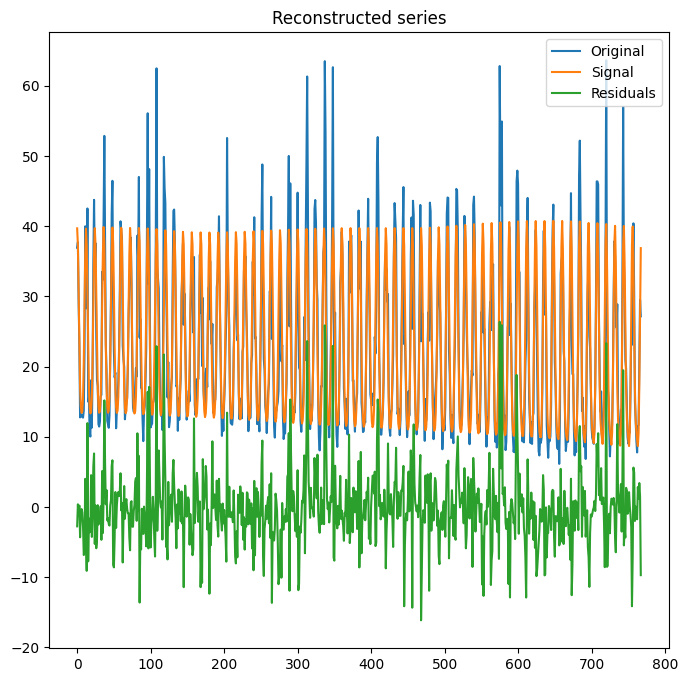

16.50713526194082

In [94]:
ts_rec = prs.reconstruct(ts_ssa, groups={"Signal": range(1, 6)})
prs.plot(ts_rec, superpose=True)
ts_mspe = 100 * np.mean( np.sqrt(( (ts_recent - ts_rec.Signal) / ts )**2)) 
ssa_results['Basic']['Reconstruct_5'] = ts_mspe
print(ts_mspe)

Мало того, что данное число компонент даст более устойчивый результат – процент ошибки оказался меньше, чем для большего числа компонент.

### Recurrent forecast
Попробуем построить рекуррентный прогноз.

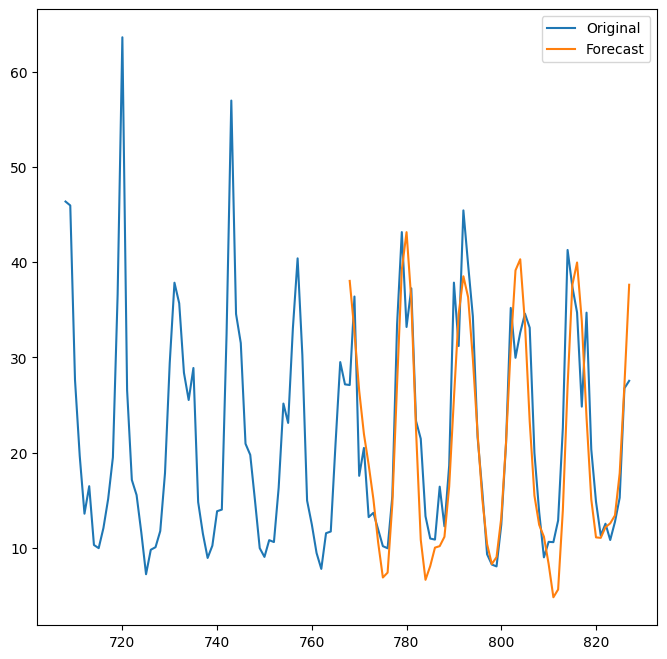

In [95]:
for_length = 12 * 5
ts_rfor = prs.rforecast(ts_ssa, groups={"Signal": range(1, 14)}, length=for_length)

ts_rfor_index = ts_actual.index
ts_rfor.Signal = pd.Series(ts_rfor.Signal, index=ts_rfor_index)

ts_original = pd.concat([ts_recent, ts_actual])
plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_rfor.Signal, label="Forecast")
plt.legend()
plt.show()

Посчитаем MSPE прогноза

In [97]:
rfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_rfor.Signal) / ts_actual )**2)) 
ssa_results['Basic']["RForecast_14"] = rfor_mspe
print(rfor_mspe)

19.79415621525057


Ошибка прогноза составила около 19.8%

Можем взять меньшее число компонент и проверить качество прогноза.

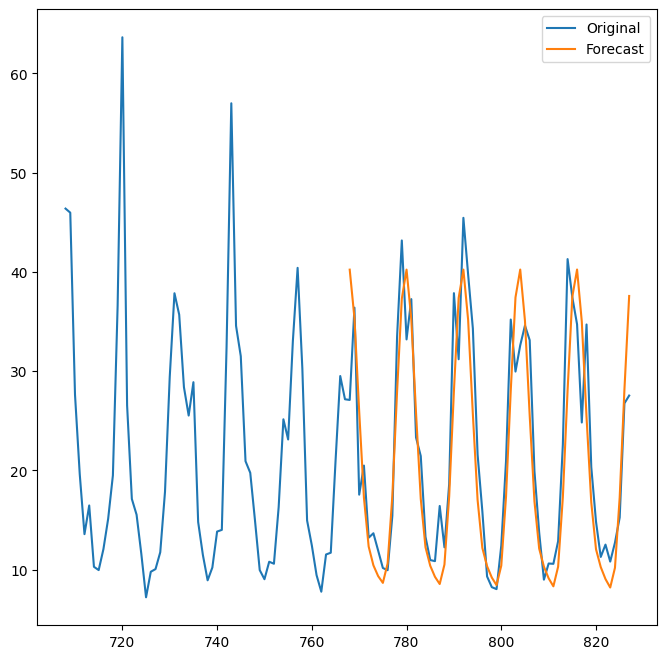

18.10501317565235


In [98]:
for_length = 12 * 5
ts_rfor = prs.rforecast(ts_ssa, groups={"Signal": range(1, 6)}, length=for_length)

ts_rfor_index = ts_actual.index
ts_rfor.Signal = pd.Series(ts_rfor.Signal, index=ts_rfor_index)

ts_original = pd.concat([ts_recent, ts_actual])
plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_rfor.Signal, label="Forecast")
plt.legend()
plt.show()

rfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_rfor.Signal) / ts_actual )**2)) 
ssa_results['Basic']["RForecast_5"] = rfor_mspe
print(rfor_mspe)

По первым пяти компонентам удалось добиться снижения ошибки до 18.1%

Построим теперь векторный прогноз.

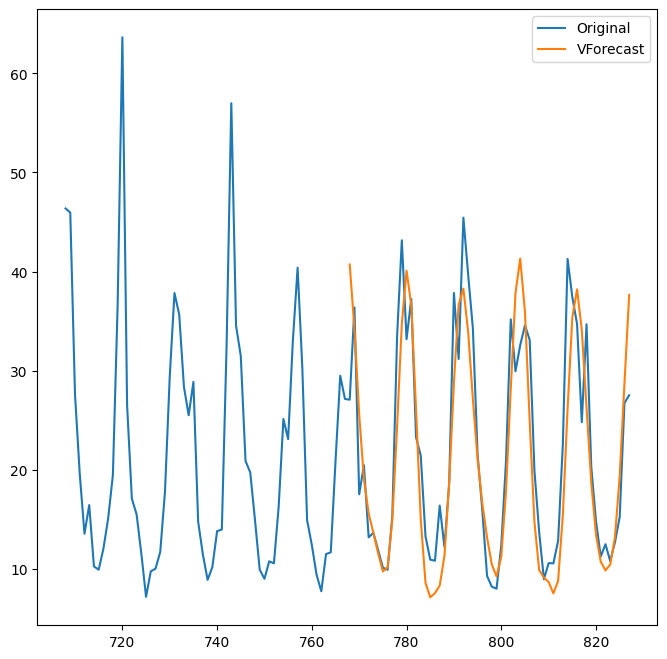

18.59729507287916


In [99]:
for_length = 12 * 5
ts_vfor = prs.vforecast(ts_ssa, groups={"Signal": range(1, 14)}, length=for_length)

ts_vfor_index = ts_actual.index
ts_vfor.Signal = pd.Series(ts_vfor.Signal, index=ts_vfor_index)

plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_vfor.Signal, label="VForecast")
plt.legend()
plt.show()


vfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_vfor.Signal) / ts_actual )**2)) 
ssa_results['Basic']["VForecast_14"] = vfor_mspe
print(vfor_mspe)

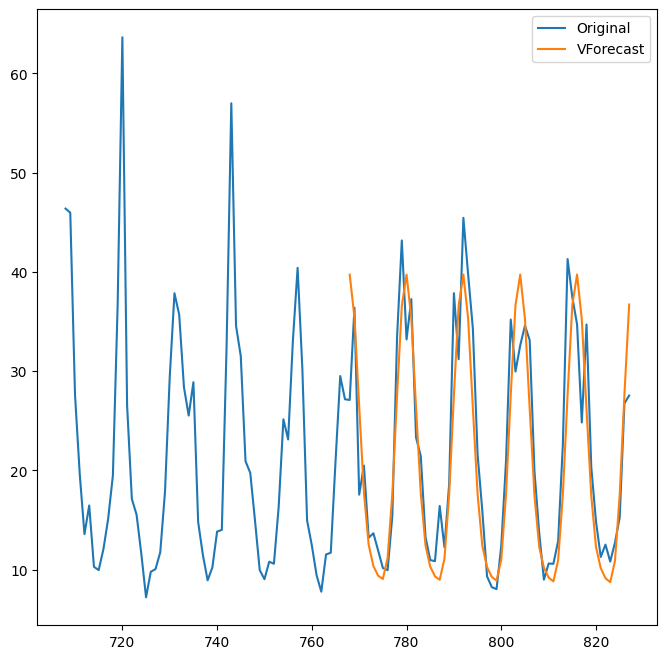

17.19020044283855


In [100]:
for_length = 12 * 5
ts_vfor = prs.vforecast(ts_ssa, groups={"Signal": range(1, 6)}, length=for_length)

ts_vfor_index = ts_actual.index
ts_vfor.Signal = pd.Series(ts_vfor.Signal, index=ts_vfor_index)

plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_vfor.Signal, label="VForecast")
plt.legend()
plt.show()


vfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_vfor.Signal) / ts_actual )**2)) 
ssa_results['Basic']["VForecast_5"] = vfor_mspe
print(vfor_mspe)

При использовании векторного прогноза получили 18.8 и 17.2% ошибки соответственно.

## Toeplitz SSA

Данный ряд выглядит как стационарный, и если это так, то применив Toeplitz SSA можем получить более точный результат. 

Сперва проверим ряд на стационарность с помощью теста Дики-Фуллера.

In [36]:
from statsmodels.tsa.stattools import adfuller

adfuller(ts)

(-5.15626993720287,
 1.0791410291068427e-05,
 21,
 806,
 {'1%': -3.438489266223099,
  '5%': -2.8651325741144573,
  '10%': -2.5686830088234025},
 5168.1661619371)

Второе значение в выводе – это p-value. Таким образом, практически для любого уровня значимости гипотеза о том, что данный ряд является стационарным, не отвергается.

Исходя из этого, построим Toeplitz SSA.

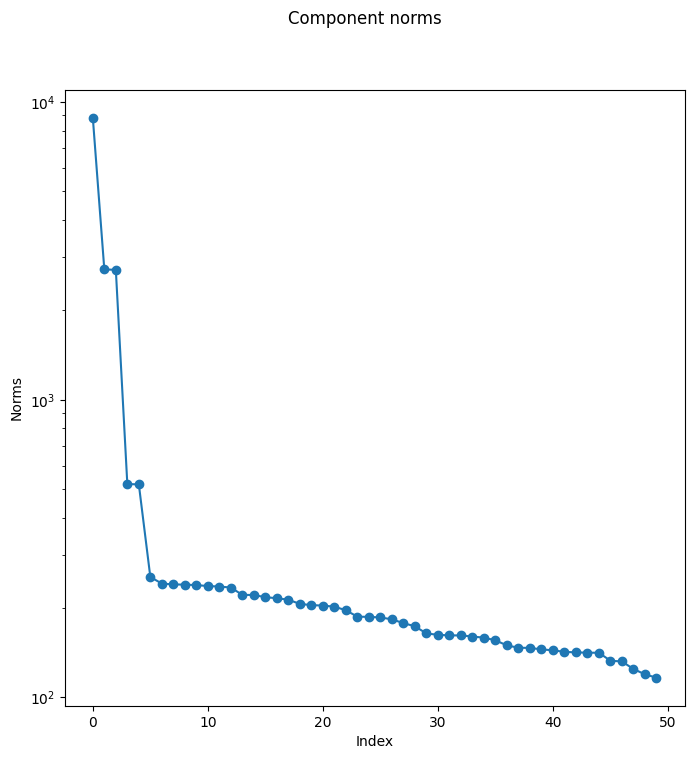

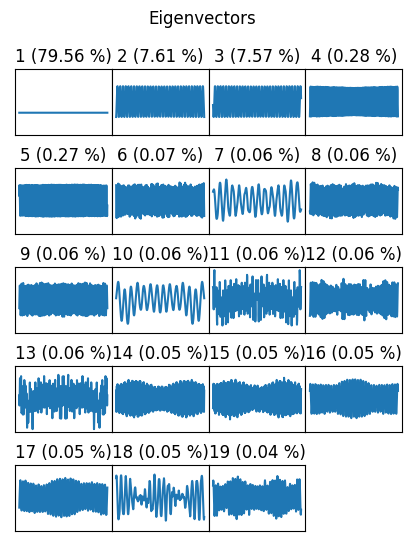

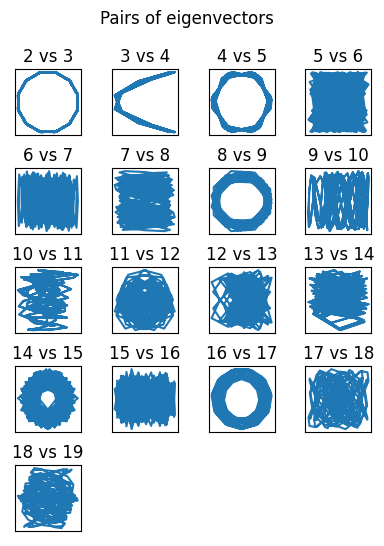

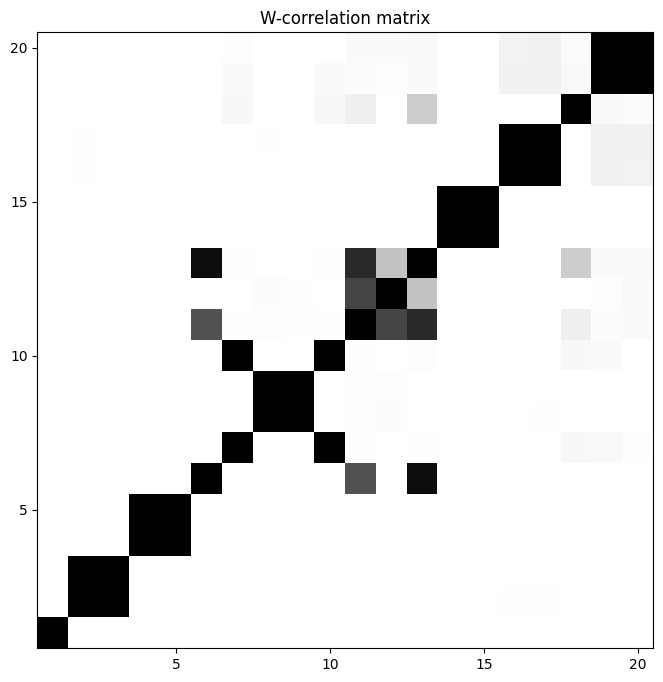

In [37]:
ts_tssa = prs.ssa(ts_recent, L=len(ts_recent) // 2 // 12 * 12, kind="toeplitz-ssa")
prs.plot(ts_tssa)
prs.plot(ts_tssa, kind="vectors", idx=range(1, 20))
prs.plot(ts_tssa, kind="paired", idx=range(2, 20), contrib=False)
prs.plot(prs.wcor(ts_tssa, groups=range(1, 21)), scales=range(5, 21, 5))

In [40]:
print(prs.parestimate(ts_tssa, groups={"Trend": 1, "Seasonality": range(2, 14)}, method="esprit"))

$Trend
   period     rate   |    Mod     Arg  |     Re        Im
      Inf   0.000000 |  1.00000   0.00 |  1.00000   0.00000

$Seasonality
   period     rate   |    Mod     Arg  |     Re        Im
   11.995   0.000000 |  1.00000   0.52 |  0.86592   0.50019
  -11.995  -0.000000 |  1.00000  -0.52 |  0.86592  -0.50019
    5.994   0.000000 |  1.00000   1.05 |  0.49913   0.86652
   -5.994   0.000000 |  1.00000  -1.05 |  0.49913  -0.86652
    7.292  -0.000000 |  1.00000   0.86 |  0.65120   0.75891
   -7.292  -0.000000 |  1.00000  -0.86 |  0.65120  -0.75891
   29.640  -0.000000 |  1.00000   0.21 |  0.97762   0.21040
  -29.640  -0.000000 |  1.00000  -0.21 |  0.97762  -0.21040
    4.867  -0.000000 |  1.00000   1.29 |  0.27611   0.96113
   -4.867   0.000000 |  1.00000  -1.29 |  0.27611  -0.96113
    9.916   0.000000 |  1.00000   0.63 |  0.80588   0.59208
   -9.916   0.000000 |  1.00000  -0.63 |  0.80588  -0.59208




В целом, результат получился достаточно похожим на предыдущий в том смысле, что после пятой компоненты происходит заметное смешивание. Однако при этом компоненты все же немного лучше отделились друг от друга.

Построим восстановление ряда.

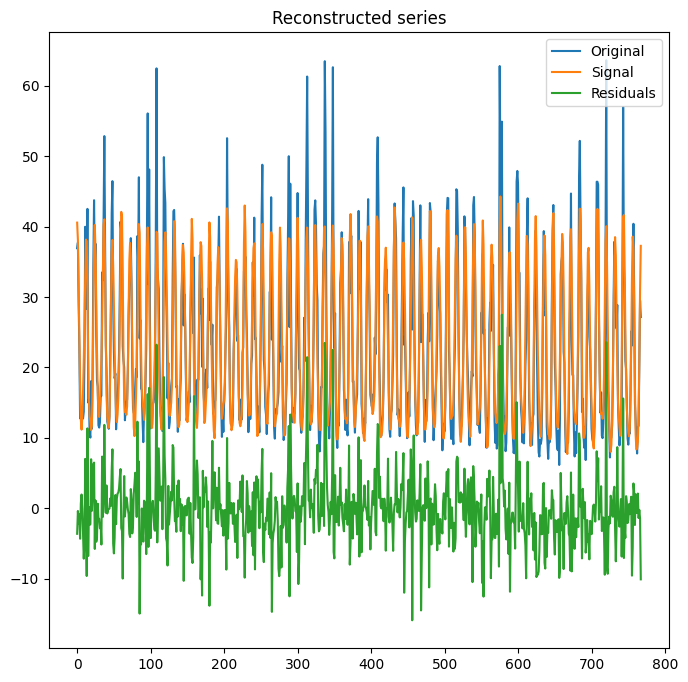

16.552903209349402


In [102]:
ts_trec = prs.reconstruct(ts_tssa, groups={"Signal": range(1, 14)})
prs.plot(ts_trec, superpose=True)
ts_tmspe = 100 * np.mean( np.sqrt(( (ts_recent - ts_trec.Signal) / ts )**2)) 
ssa_results['Toeplitz'] = {"Reconstruct_14": ts_tmspe}
print(ts_tmspe)

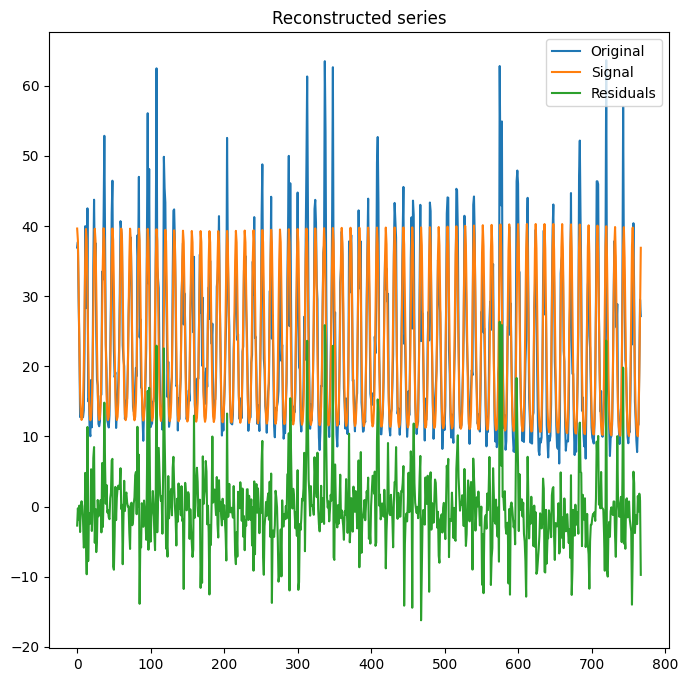

16.94318997065084


In [103]:
ts_trec = prs.reconstruct(ts_tssa, groups={"Signal": range(1, 6)})
prs.plot(ts_trec, superpose=True)
ts_tmspe = 100 * np.mean( np.sqrt(( (ts_recent - ts_trec.Signal) / ts )**2)) 
ssa_results['Toeplitz']['Reconstruct_5'] = ts_tmspe
print(ts_tmspe)

В данном случае при восстановлении результат для 14 компонент оказался лучше, чем для Basic SSA (16.6 в Basic, 16.55 в Toeplitz), однако хуже для 5 компонент (16.5 в Basic, 16.95 в Toeplitz).

Построим прогноз.

## Toeplitz Forecast

### Recurrent forecast
Попробуем построить рекуррентный прогноз.

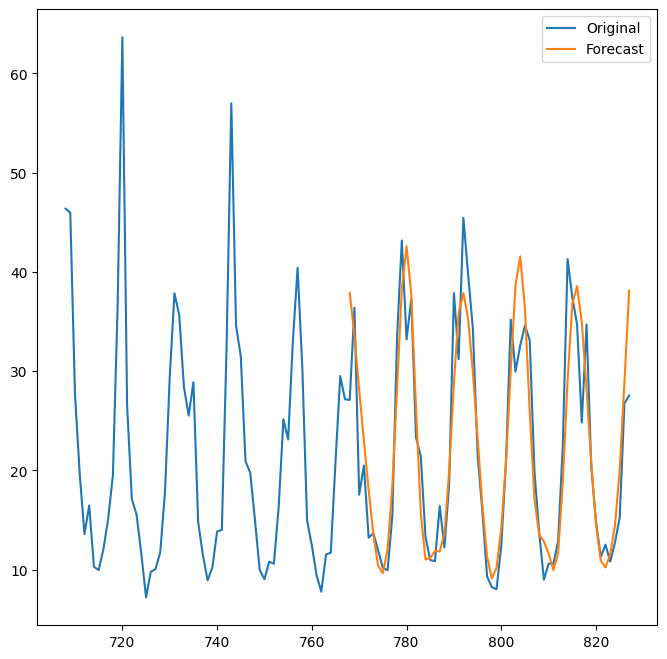

In [104]:
for_length = 12 * 5
ts_trfor = prs.rforecast(ts_tssa, groups={"Signal": range(1, 14)}, length=for_length)

ts_trfor_index = ts_actual.index
ts_trfor.Signal = pd.Series(ts_trfor.Signal, index=ts_trfor_index)

ts_original = pd.concat([ts_recent, ts_actual])
plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_trfor.Signal, label="Forecast")
plt.legend()
plt.show()

Посчитаем MSPE прогноза

In [106]:
trfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_trfor.Signal) / ts_actual )**2)) 
ssa_results['Toeplitz']['RForecast_14'] = trfor_mspe
print(trfor_mspe)

16.239360651642006


Ошибка прогноза составила около 16.2% (против 19.8% для Basic).

Можем взять меньшее число компонент и проверить качество прогноза.

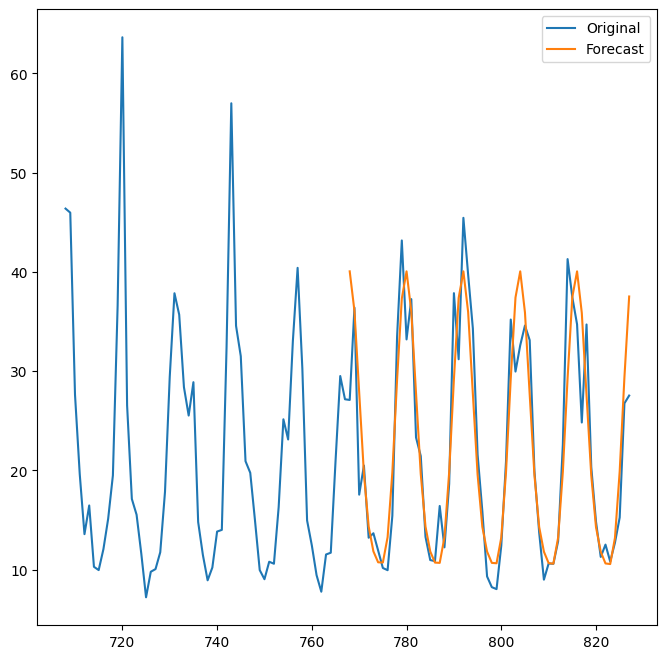

15.26819927818054


In [107]:
for_length = 12 * 5
ts_trfor = prs.rforecast(ts_tssa, groups={"Signal": range(1, 6)}, length=for_length)

ts_trfor_index = ts_actual.index
ts_trfor.Signal = pd.Series(ts_trfor.Signal, index=ts_trfor_index)

ts_original = pd.concat([ts_recent, ts_actual])
plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_trfor.Signal, label="Forecast")
plt.legend()
plt.show()
trfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_trfor.Signal) / ts_actual )**2)) 
ssa_results['Toeplitz']['RForecast_5'] = trfor_mspe
print(trfor_mspe)

По первым пяти компонентам удалось добиться снижения ошибки до 15.2% (Против 18.1% для Basic).

Построим теперь векторный прогноз.

### Vector forecast

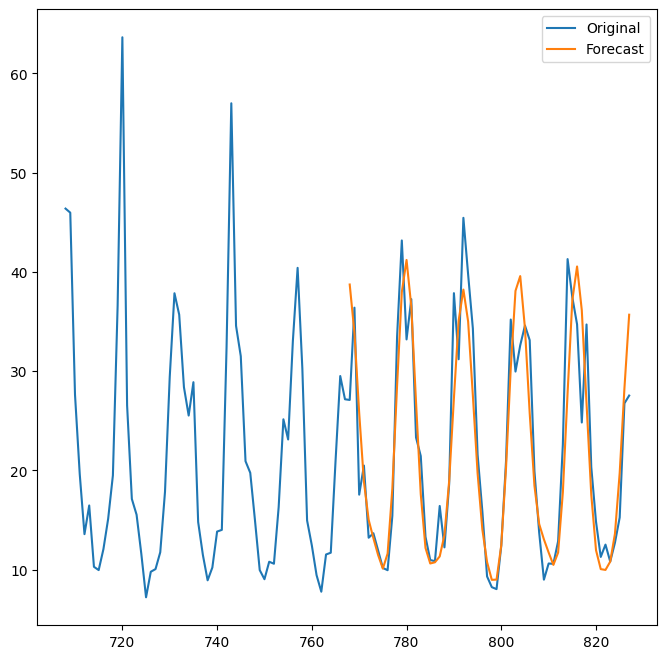

14.861453360704449


In [108]:
for_length = 12 * 5
ts_tvfor = prs.vforecast(ts_tssa, groups={"Signal": range(1, 14)}, length=for_length)

ts_tvfor_index = ts_actual.index
ts_tvfor.Signal = pd.Series(ts_tvfor.Signal, index=ts_tvfor_index)

ts_original = pd.concat([ts_recent, ts_actual])
plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_tvfor.Signal, label="Forecast")
plt.legend()
plt.show()

tvfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_tvfor.Signal) / ts_actual )**2)) 
ssa_results['Toeplitz']['VForecast_14'] = tvfor_mspe
print(tvfor_mspe)

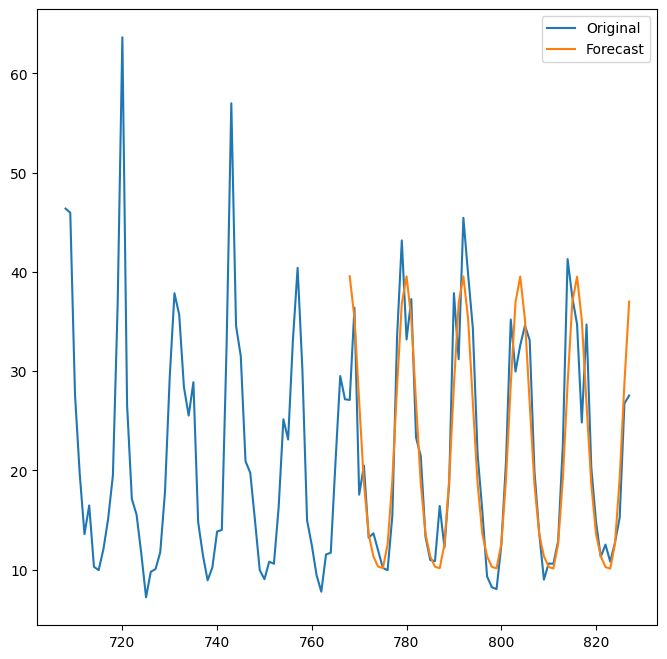

14.893247088719749


In [109]:
for_length = 12 * 5
ts_tvfor = prs.vforecast(ts_tssa, groups={"Signal": range(1, 6)}, length=for_length)

ts_tvfor_index = ts_actual.index
ts_tvfor.Signal = pd.Series(ts_tvfor.Signal, index=ts_tvfor_index)

ts_original = pd.concat([ts_recent, ts_actual])
plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_tvfor.Signal, label="Forecast")
plt.legend()
plt.show()


tvfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_tvfor.Signal) / ts_actual )**2))
ssa_results['Toeplitz']['VForecast_5'] = tvfor_mspe
print(tvfor_mspe)

При использовании векторного прогноза для Toeplitz получили 14.86 и 14.89% (Против 18.6 и 17.2% для Basic).

In [110]:
ssa_results

{'Basic': {'Reconstruct_14': 16.62997710434034,
  'Reconstruct_5': 16.50713526194082,
  'RForecast': 19.79415621525057,
  'RForecast_14': 19.79415621525057,
  'RForecast_5': 18.10501317565235,
  'VForecast_14': 18.59729507287916,
  'VForecast_5': 17.19020044283855},
 'Toeplitz': {'Reconstruct_14': 16.552903209349402,
  'Reconstruct_5': 16.94318997065084,
  'RForecast_14': 16.239360651642006,
  'RForecast_5': 15.26819927818054,
  'VForecast_14': 14.861453360704449,
  'VForecast_5': 14.893247088719749}}

## Results table

Для более удобного визуального восприятия результаты приведены в таблице ниже.

**Строки** – использованные виды SSA.

**Столбцы** – выполненные действия: слово в названии колонки – восстановление, рекуррентый или векторный прогноз; число – количество использованных компонент.


In [123]:
kinds = list(ssa_results.keys())
classes = list(ssa_results[kinds[0]].keys())
df = pd.DataFrame([ssa_results[i].values() for i in ssa_results], kinds, classes)
df

,Reconstruct_14,Reconstruct_5,RForecast_14,RForecast_5,VForecast_14,VForecast_5
Basic,16.629977,16.507135,19.794156,18.105013,18.597295,17.190200
Toeplitz,16.552903,16.943190,16.239361,15.268199,14.861453,14.893247


Исходя из таблицы выше, лучшего результата на промежутке пяти лет удалось добиться для векторного прогноза на основе Toeplitz SSA по 14 компонентам. Однако, для большей устойчивости можно пренебречь 3 процентными пунктами и выбрать векторный прогноз по 5 компонентам, получив ошибку около 14.9%